# Compare SPELL vs counts correlation

This notebook performs an experiment to determine which correlation matrix we should use
1. Correlation of the MR counts expression matrix
2. Correlation of the MR counts that have been processed using SPELL

The correlation of the counts matrix relates how similar a pair of genes are based on their expression profiles - **relates genes over samples**.
High correlation means that a pair of genes have a similar expression profiles - i.e. similar levels of expression across samples/contexts, so genes both have low expression in the same samples and high expression in the same samples.
* Pro: Easy to interpret
* Con: Many gene pairs found to have a high correlation because many genes are related to the same pathway have the similar expression profiles. This is consistent with [Myers et al.](https://link.springer.com/article/10.1186/1471-2164-7-187), who found that there can be an over-representation of genes associated with the same pathway (i.e. a large fraction of gene pairs represent ribosomal relationships). This very prominent signal makes it difficult to detect other signals. Figure 1C demonstrates that a large fraction of gene pairs are ribosomal relationships - in the top 0.1% most co-expressed genes, 99% belong to the ribosome pathway. Furthermore, protein function prediction based on co-expression drop dramatically after removing the ribisome pathway (Figure 1A, B).

To try to remove this very dominant global signal in the data. Here we are applying dimensionality reduction techniques in addition to scaling the data using a method called SPELL.
The correlation of the SPELL matrix relates genes based on the gene coefficient matrix - **relate genes over their contribution to singular vectors (linear combination of genes - linear relationship between genes)**.
High correlation means that a pair of genes contributes similarly to a singular vector, which are the axes pointing in the direction of the spread of the data and capture how genes are related to each other
* Pro: Gene contributions are more balanced so that redundant signals (i.e. many genes from the same pathway - genes that vary together) are represented by a few SVs as opposed to many samples. More balanced also means that more subtle signals can be amplified (i.e. genes related by a smaller pathway are also captured by a few SVs)
* Con: Can amplify noise - i.e. an SV that corresponds to some technical source of variability now has a similar weight to other real signals

For more information comparing using counts vs SPELL-processing see: https://docs.google.com/presentation/d/18E0boNODJaxP-YYNIlccrh0kASbc7bapQBMovOX62jw/edit#slide=id.gf9d09c6be6_0_0

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## User params

In [2]:
# Threshold to use to define edges between genes
# Top X% of genes are used
top_percent = 0.01

# Regulon file
regulon_filename = "gene_sets_refs.csv"

## Load correlation matrix

In [3]:
pao1_corr_filename = paths.PAO1_CORR_RAW
pao1_corr_spell_filename = paths.PAO1_CORR_LOG_SPELL

In [4]:
# Load correlation data
pao1_corr_counts = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pao1_corr_spell = pd.read_csv(pao1_corr_spell_filename, sep="\t", index_col=0, header=0)

## Make edge matrix

Convert correlation matrix of continuous values to an adjacency matrix with 1's if the correlation between a pair of genes exceeds the user defined threshold and therefore indicates if an edge exits those pair of genes.

In [5]:
# Get threshold to use based on percentage
def get_corr_threshold(corr_df, top_percent):
    # Since we are using the distribution of scores to determine the threshold
    # we need to remove duplicates and also the diagonal values
    # Here we get lower triangular matrix values only
    tril_corr_df = corr_df.where(~np.triu(np.ones(corr_df.shape)).astype(np.bool))

    # Flatten dataframe
    flat_corr_df = tril_corr_df.stack().reset_index()
    flat_corr_df.columns = ["gene_1", "gene_2", "corr_value"]

    # Get quantile
    # TO DO:Take abs????
    threshold = flat_corr_df.quantile(1 - top_percent)["corr_value"]
    print("correlation threshold: ", threshold)

    # Verify that number of gene pairs above the threshold
    # is approximately equal to the `top_percent`
    total_genes = flat_corr_df.shape[0]
    num_genes_above = flat_corr_df[flat_corr_df["corr_value"] > threshold].shape[0]
    percent_genes_above = num_genes_above / total_genes
    print("percent of pairs exceeding threshold: ", percent_genes_above)

    return threshold

In [6]:
pao1_corr_counts_threshold = get_corr_threshold(pao1_corr_counts, top_percent)

correlation threshold:  0.542203028482133
percent of pairs exceeding threshold:  0.010000062699154653


In [7]:
pao1_corr_spell_threshold = get_corr_threshold(pao1_corr_spell, top_percent)

correlation threshold:  0.296208990816415
percent of pairs exceeding threshold:  0.010000062699154653


In [8]:
# Create adjacency matrix using threshold defined above
# The adjacency matrix will determine the strength of the connection between two genes
# If the concordance is strong enough (i.e. above the threshold), then
# the genes are connected by an edge
# TO DO:abs?????
pao1_counts_adj = (pao1_corr_counts > pao1_corr_counts_threshold).astype(float)
pao1_spell_adj = (pao1_corr_spell > pao1_corr_spell_threshold).astype(float)

In [9]:
pao1_counts_adj.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
PA0002,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
PA0003,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
PA0004,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
PA0005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
pao1_spell_adj.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0002,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0003,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0004,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA0005,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluate relationships captured

Given a set of known gene regulons, that we expect to be clustered together, let's calculate we want to evaluate which correlation matrix captures these geneset relationships better. To determine this we calculate the percentage of within (i.e. edges connecting two genes within the geneset) compared to the percentage of edges between(i.e.edges connecting a gene within the geneset and some other external gene).

In [11]:
# Load regulon data
regulon_df = pd.read_csv(regulon_filename, header=0, index_col=0)

In [12]:
# Format regulon data
regulon_df["Genes"] = regulon_df["Genes"].str.split(";").apply(list)

In [13]:
print(regulon_df.shape)
regulon_df.head()

(31, 2)


,Lengths,Genes
Regulon,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434..."
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016..."
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241..."
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422..."
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013..."


In [14]:
def compare_within_btwn_edge(adj_df, regulon_df):
    """
    For each input regulon/geneset, this function calculates the
    percentage of edges within genes in the regulon vs the
    percentage of edges between genes in the regulon and some other
    gene.

    This function returns a dataframe containing the percentages for
    each regulon
    """

    # Loop through each regulon
    rows = []
    for regulon_name in regulon_df.index:
        geneset = regulon_df.loc[regulon_name, "Genes"]
        print(geneset)
        print(len(geneset))

        # Since there are some gene ids that are from PA14
        # We will take the intersection
        geneset_processed = set(geneset).intersection(adj_df.index)

        # Get within edges
        within_df = adj_df.loc[geneset_processed, geneset_processed]
        tril_within_df = within_df.where(
            ~np.triu(np.ones(within_df.shape)).astype(np.bool)
        )
        # print(tril_within_df)

        flat_within_df = tril_within_df.stack().reset_index()
        flat_within_df.columns = ["gene_1", "gene_2", "edge"]
        total_within_pairs = flat_within_df.shape[0]
        # print(flat_within_df)

        # count the number of within edges
        num_within_edges = flat_within_df["edge"].sum()
        print(num_within_edges)

        # Get between edges
        not_geneset = set(adj_df.index).difference(geneset_processed)
        between_df = adj_df.loc[geneset_processed, not_geneset]
        # tril_between_df = between_df.where(~np.triu(np.ones(between_df.shape)).astype(np.bool))

        flat_between_df = between_df.stack().reset_index()
        flat_between_df.columns = ["gene_1", "gene_2", "edge"]
        total_between_pairs = flat_between_df.shape[0]

        # count the number of within edges
        num_between_edges = flat_between_df["edge"].sum()
        print(num_between_edges)

        # Get the proportion of 1's looking at within and between genes
        total_pairs = total_within_pairs + total_between_pairs
        prop_within = num_within_edges / total_pairs
        prop_between = num_between_edges / total_pairs
        print("within", prop_within)
        print("between", prop_between)

        # Make output df
        rows.append(
            {
                "Regulon": regulon_name,
                "Lengths": regulon_df.loc[regulon_name, "Lengths"],
                "Genes": geneset,
                "% within edges": prop_within,
                "% between edges": prop_between,
            }
        )
    output_df = pd.DataFrame(rows)
    print(output_df)

    return output_df

In [15]:
pao1_counts_stats = compare_within_btwn_edge(pao1_counts_adj, regulon_df)

['PA5475', 'PA1673', 'PA5027', 'PA3337', 'PA4348', 'PA4347', 'PA4346', 'PA0527', 'PA2119', 'PA0200', 'PA0519', 'PA0518', 'PA0517', 'PA0516', 'PA0515', 'PA0514', 'PA0513', 'PA0512', 'PA0511', 'PA0510', 'PA0509', 'PA1546', 'PA5232', 'PA5231', 'PA5230', 'PA4577', 'PA0141', 'PA1746', 'PA1557', 'PA1556', 'PA1555', 'PA1554', 'PA4067', 'PA5427', 'PA4352', 'PA2127', 'PA2126', 'PA2125', 'PA3930', 'PA3929', 'PA3928', 'PA4587', 'PA0024', 'PA0459', 'PA0520', 'PA0521', 'PA0522', 'PA0523', 'PA0524', 'PA0525', 'PA0526', 'PA0836', 'PA1561', 'PA1789', 'PA1863', 'PA1862', 'PA1861', 'PA2193', 'PA2194', 'PA2195', 'PA3190', 'PA3309', 'PA3391', 'PA3877', 'PA3876', 'PA3878', 'PA3879', 'PA4236', 'PA4328', 'PA4922', 'PA5170', 'PA5171']
72
289.0
1482.0
within 0.0007262985413713723
between 0.003724479025302331
['PA0050', 'PA0051', 'PA0082', 'PA0102', 'PA0105', 'PA0165', 'PA0185', 'PA0186', 'PA0285', 'PA0291', 'PA0347', 'PA0450', 'PA0451', 'PA0455', 'PA0456', 'PA0572', 'PA0594', 'PA4212', 'PA4167', 'PA4142', 'PA4

3234.0
within 0.0002910413824465666
between 0.004525133802077867
['PA0007', 'PA0059', 'PA0105', 'PA0106', 'PA0107', 'PA0122', 'PA0197', 'PA0198', 'PA0199', 'PA0201', 'PA0229', 'PA0230', 'PA0265', 'PA0266', 'PA0269', 'PA0270', 'PA0271', 'PA0281', 'PA0283', 'PA0284', 'PA0333', 'PA0423', 'PA0446', 'PA0447', 'PA0534', 'PA0547', 'PA0622', 'PA0623', 'PA0628', 'PA0641', 'PA0737', 'PA0746', 'PA0806', 'PA0852', 'PA0866', 'PA0910', 'PA0996', 'PA0997', 'PA0998', 'PA0999', 'PA1000', 'PA1001', 'PA1002', 'PA1134', 'PA1168', 'PA1169', 'PA1211', 'PA1212', 'PA1213', 'PA1214', 'PA1215', 'PA1216', 'PA1217', 'PA1218', 'PA1219', 'PA1220', 'PA1221', 'PA1242', 'PA1300', 'PA1323', 'PA1404', 'PA1471', 'PA1516', 'PA1541', 'PA1559', 'PA1560', 'PA1669', 'PA1797', 'PA1838', 'PA1869', 'PA1870', 'PA1874', 'PA1875', 'PA1876', 'PA1901', 'PA1902', 'PA1903', 'PA1904', 'PA1905', 'PA1914', 'PA1984', 'PA1991', 'PA1999', 'PA2000', 'PA2006', 'PA2008', 'PA2009', 'PA2011', 'PA2013', 'PA2014', 'PA2018', 'PA2019', 'PA2033', 'PA2

612.0
6284.0
within 0.0005266201313452563
between 0.005407321740806521
['PA0044', 'PA0169', 'PA0170', 'PA0171', 'PA0175', 'PA0176', 'PA0282', 'PA0295', 'PA0423', 'PA0434', 'PA0472', 'PA0484', 'PA0511', 'PA0513', 'PA0514', 'PA0515', 'PA0516', 'PA0517', 'PA0518', 'PA0519', 'PA0622', 'PA0704', 'PA0807', 'PA0887', 'PA0918', 'PA0985', 'PA0996', 'PA0997', 'PA0998', 'PA0999', 'PA1000', 'PA1001', 'PA1002', 'PA1003', 'PA1041', 'PA1070', 'PA1071', 'PA1072', 'PA1073', 'PA1074', 'PA1168', 'PA1169', 'PA1202', 'PA1216', 'PA1217', 'PA1246', 'PA1288', 'PA1339', 'PA1340', 'PA1341', 'PA1342', 'PA1354', 'PA1363', 'PA1546', 'PA1554', 'PA1555', 'PA1557', 'PA1581', 'PA1582', 'PA1596', 'PA1706', 'PA1707', 'PA1708', 'PA1709', 'PA1710', 'PA1711', 'PA1712', 'PA1714', 'PA1718', 'PA1719', 'PA1733', 'PA1745', 'PA1761', 'PA1837', 'PA1838', 'PA1888', 'PA1894', 'PA1895', 'PA1901', 'PA1902', 'PA1903', 'PA1904', 'PA1905', 'PA1984', 'PA2034', 'PA2360', 'PA2368', 'PA2371', 'PA2372', 'PA2390', 'PA2566', 'PA2624', 'PA2699'

In [16]:
pao1_spell_stats = compare_within_btwn_edge(pao1_spell_adj, regulon_df)

['PA5475', 'PA1673', 'PA5027', 'PA3337', 'PA4348', 'PA4347', 'PA4346', 'PA0527', 'PA2119', 'PA0200', 'PA0519', 'PA0518', 'PA0517', 'PA0516', 'PA0515', 'PA0514', 'PA0513', 'PA0512', 'PA0511', 'PA0510', 'PA0509', 'PA1546', 'PA5232', 'PA5231', 'PA5230', 'PA4577', 'PA0141', 'PA1746', 'PA1557', 'PA1556', 'PA1555', 'PA1554', 'PA4067', 'PA5427', 'PA4352', 'PA2127', 'PA2126', 'PA2125', 'PA3930', 'PA3929', 'PA3928', 'PA4587', 'PA0024', 'PA0459', 'PA0520', 'PA0521', 'PA0522', 'PA0523', 'PA0524', 'PA0525', 'PA0526', 'PA0836', 'PA1561', 'PA1789', 'PA1863', 'PA1862', 'PA1861', 'PA2193', 'PA2194', 'PA2195', 'PA3190', 'PA3309', 'PA3391', 'PA3877', 'PA3876', 'PA3878', 'PA3879', 'PA4236', 'PA4328', 'PA4922', 'PA5170', 'PA5171']
72
638.0
2281.0
within 0.0016033857072489117
between 0.005732480874976125
['PA0050', 'PA0051', 'PA0082', 'PA0102', 'PA0105', 'PA0165', 'PA0185', 'PA0186', 'PA0285', 'PA0291', 'PA0347', 'PA0450', 'PA0451', 'PA0455', 'PA0456', 'PA0572', 'PA0594', 'PA4212', 'PA4167', 'PA4142', 'PA4

4810.0
within 0.0005582957288277888
between 0.0067303319690768535
['PA0007', 'PA0059', 'PA0105', 'PA0106', 'PA0107', 'PA0122', 'PA0197', 'PA0198', 'PA0199', 'PA0201', 'PA0229', 'PA0230', 'PA0265', 'PA0266', 'PA0269', 'PA0270', 'PA0271', 'PA0281', 'PA0283', 'PA0284', 'PA0333', 'PA0423', 'PA0446', 'PA0447', 'PA0534', 'PA0547', 'PA0622', 'PA0623', 'PA0628', 'PA0641', 'PA0737', 'PA0746', 'PA0806', 'PA0852', 'PA0866', 'PA0910', 'PA0996', 'PA0997', 'PA0998', 'PA0999', 'PA1000', 'PA1001', 'PA1002', 'PA1134', 'PA1168', 'PA1169', 'PA1211', 'PA1212', 'PA1213', 'PA1214', 'PA1215', 'PA1216', 'PA1217', 'PA1218', 'PA1219', 'PA1220', 'PA1221', 'PA1242', 'PA1300', 'PA1323', 'PA1404', 'PA1471', 'PA1516', 'PA1541', 'PA1559', 'PA1560', 'PA1669', 'PA1797', 'PA1838', 'PA1869', 'PA1870', 'PA1874', 'PA1875', 'PA1876', 'PA1901', 'PA1902', 'PA1903', 'PA1904', 'PA1905', 'PA1914', 'PA1984', 'PA1991', 'PA1999', 'PA2000', 'PA2006', 'PA2008', 'PA2009', 'PA2011', 'PA2013', 'PA2014', 'PA2018', 'PA2019', 'PA2033', 'PA

6753.0
within 0.0006300281089463991
between 0.006818236890568964
['PA0044', 'PA0493', 'PA0494', 'PA0510', 'PA0511', 'PA0514', 'PA0515', 'PA0516', 'PA0517', 'PA0518', 'PA0519', 'PA0523', 'PA0524', 'PA0572', 'PA0752', 'PA0753', 'PA0754', 'PA0755', 'PA0807', 'PA0866', 'PA0887', 'PA0996', 'PA0997', 'PA0998', 'PA0999', 'PA1000', 'PA1001', 'PA1002', 'PA1071', 'PA1072', 'PA1073', 'PA1074', 'PA1123', 'PA1183', 'PA1228', 'PA1246', 'PA1337', 'PA1339', 'PA1342', 'PA1556', 'PA1561', 'PA1579', 'PA1617', 'PA1633', 'PA1634', 'PA1650', 'PA1657', 'PA1658', 'PA1659', 'PA1694', 'PA1706', 'PA1707', 'PA1708', 'PA1709', 'PA1710', 'PA1711', 'PA1712', 'PA1714', 'PA1718', 'PA1719', 'PA1720', 'PA1721', 'PA1722', 'PA1763', 'PA1892', 'PA1893', 'PA1894', 'PA1895', 'PA1896', 'PA1897', 'PA1984', 'PA1992', 'PA2001', 'PA2113', 'PA2191', 'PA2247', 'PA2321', 'PA2379', 'PA2453', 'PA2533', 'PA2566', 'PA2780', 'PA3038', 'PA3079', 'PA3187', 'PA3188', 'PA3189', 'PA3190', 'PA3234', 'PA3235', 'PA3361', 'PA3363', 'PA3365', 'PA3

In [17]:
print(pao1_counts_stats.shape)
pao1_counts_stats

(31, 5)


,Regulon,Lengths,Genes,% within edges,% between edges
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",0.000726,0.003724
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",0.000350,0.007804
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",0.001157,0.010080
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",0.000915,0.009643
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",0.000708,0.007960
5,LasR_regulon,183,"[PA0007, PA0026, PA0027, PA0028, PA0050, PA005...",0.000668,0.004740
6,RhlR_regulon,123,"[PA0059, PA0109, PA0132, PA0144, PA0175, PA017...",0.000733,0.007268
7,PqsR_regulon,133,"[PA0122, PA0355, PA0567, PA0996, PA0997, PA099...",0.000291,0.004525
8,QscR_regulon,405,"[PA0007, PA0059, PA0105, PA0106, PA0107, PA012...",0.000943,0.004921
9,VreI_regulon,30,"[PA0149, PA0532, PA0674, PA0675, PA0676, PA067...",0.000847,0.011519


In [18]:
print(pao1_spell_stats.shape)
pao1_spell_stats.head()

(31, 5)


,Regulon,Lengths,Genes,% within edges,% between edges
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",0.001603,0.005732
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",0.000581,0.008108
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",0.001144,0.005593
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",0.000945,0.001440
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",0.001368,0.008561


In [19]:
# Save dataframes with threshold info
pao1_counts_stats.to_csv(f"pao1_counts_network_top_{top_percent}.tsv", sep="\t")
pao1_spell_stats.to_csv(f"pao1_spell_network_top_{top_percent}.tsv", sep="\t")

In [20]:
# Format data for plotting
pao1_counts_stats_melt = pd.melt(
    pao1_counts_stats.reset_index(),
    id_vars=["Regulon", "Lengths", "Genes"],
    value_vars=["% within edges", "% between edges"],
)

pao1_spell_stats_melt = pd.melt(
    pao1_spell_stats.reset_index(),
    id_vars=["Regulon", "Lengths", "Genes"],
    value_vars=["% within edges", "% between edges"],
)

In [21]:
print(pao1_counts_stats_melt.shape)
pao1_counts_stats_melt

(62, 5)


,Regulon,Lengths,Genes,variable,value
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",% within edges,0.000726
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",% within edges,0.000350
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",% within edges,0.001157
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",% within edges,0.000915
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",% within edges,0.000708
...,...,...,...,...,...
57,LexA_regulon,15,"[PA3008, PA3007, PA3413, PA4763, PA2288, PA341...",% between edges,0.006061
58,GS_genes,3,"[PA0482, PA1376, PA2634]",% between edges,0.003117
59,ErdR_regulon,16,"[PA3604, PA1992, PA1976, PA1978, PA1979, PA198...",% between edges,0.003758
60,SoxR_regulon,6,"[PA2274, PA3718, PA4206, PA4307, PA4208]",% between edges,0.003921


In [22]:
print(pao1_spell_stats_melt.shape)
pao1_spell_stats_melt

(62, 5)


,Regulon,Lengths,Genes,variable,value
0,Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",% within edges,0.001603
1,PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",% within edges,0.000581
2,PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",% within edges,0.001144
3,PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",% within edges,0.000945
4,AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",% within edges,0.001368
...,...,...,...,...,...
57,LexA_regulon,15,"[PA3008, PA3007, PA3413, PA4763, PA2288, PA341...",% between edges,0.007225
58,GS_genes,3,"[PA0482, PA1376, PA2634]",% between edges,0.011928
59,ErdR_regulon,16,"[PA3604, PA1992, PA1976, PA1978, PA1979, PA198...",% between edges,0.005919
60,SoxR_regulon,6,"[PA2274, PA3718, PA4206, PA4307, PA4208]",% between edges,0.004820


Text(0.5, 0.98, '% within vs between edges (using top 0.01%) per regulon')

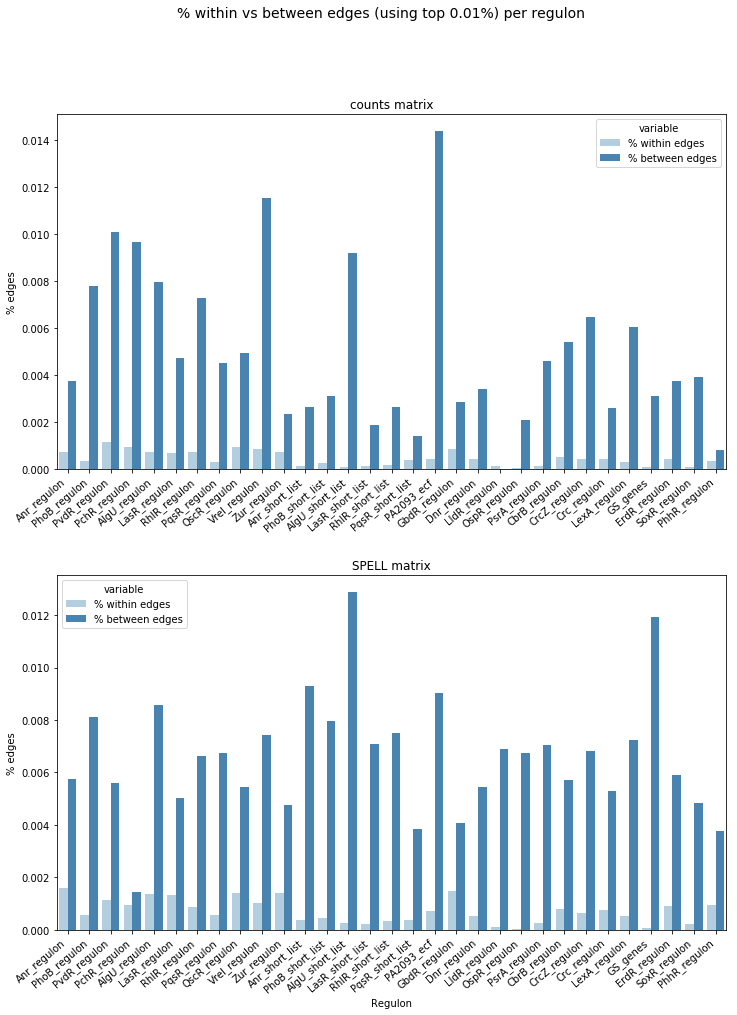

In [23]:
# Make breakdown plot per regulon to see how each contributes
fig1, axes1 = plt.subplots(ncols=1, nrows=2, figsize=(12, 15))

fig1 = sns.barplot(
    data=pao1_counts_stats_melt,
    x="Regulon",
    y="value",
    hue="variable",
    palette="Blues",
    ax=axes1[0],
)
fig1 = sns.barplot(
    data=pao1_spell_stats_melt,
    x="Regulon",
    y="value",
    hue="variable",
    palette="Blues",
    ax=axes1[1],
)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3
)
axes1[0].set_xticklabels(axes1[0].get_xticklabels(), rotation=40, ha="right")
axes1[1].set_xticklabels(axes1[1].get_xticklabels(), rotation=40, ha="right")
axes1[0].set_title("counts matrix")
axes1[1].set_title("SPELL matrix")
axes1[0].set_ylabel("% edges")
axes1[1].set_ylabel("% edges")
axes1[0].set_xlabel("")
axes1[1].set_xlabel("Regulon")
plt.suptitle(
    f"% within vs between edges (using top {top_percent}%) per regulon", fontsize=14
)

**Check:**

We noticed that there is a spike in the % of between edges for the *Anr_short_list*. We suspect that these between genes are connected to the other Anr_regulon genes that were removed in this short list. Let's check this.

In [24]:
pao1_spell_stats_test = pao1_spell_stats.set_index("Regulon")

In [25]:
pao1_spell_stats_test.loc[["Anr_regulon", "Anr_short_list"]]

,Lengths,Genes,% within edges,% between edges
Regulon,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",0.001603,0.005732
Anr_short_list,5,"[PA1673, PA1557, PA5427, PA1555, PA1556]",0.000360,0.009281


In [26]:
# Get genes from the Anr regulon and the short list
anr_regulon_genes = pao1_spell_stats_test.loc["Anr_regulon", "Genes"]
anr_short_genes = pao1_spell_stats_test.loc["Anr_short_list", "Genes"]

In [27]:
# Get genes removed from the short list
anr_short_missing_genes = list(set(anr_regulon_genes).difference(set(anr_short_genes)))
print(len(anr_short_missing_genes))
assert len(anr_short_missing_genes) == 72 - 5

67


In [28]:
# Examine between relationships
# Get within edges
within_df = pao1_spell_adj.loc[anr_short_genes, anr_short_genes]
tril_within_df = within_df.where(~np.triu(np.ones(within_df.shape)).astype(np.bool))
flat_within_df = tril_within_df.stack().reset_index()
flat_within_df.columns = ["gene_1", "gene_2", "edge"]
total_within_pairs = flat_within_df.shape[0]

# count the number of within edges
num_within_edges = flat_within_df["edge"].sum()
print(num_within_edges)

10.0


In [29]:
pao1_spell_adj.loc[anr_short_genes, anr_short_missing_genes]

,PA0200,PA0513,PA4352,PA1746,PA2125,PA1863,PA0523,PA3879,PA4587,PA0525,...,PA5232,PA5027,PA4348,PA5170,PA0141,PA3876,PA0520,PA4346,PA0516,PA1554
PA1673,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
PA1557,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
PA5427,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
PA1555,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
PA1556,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Get between edges
between_df = pao1_spell_adj.loc[anr_short_genes, anr_short_missing_genes]
tril_between_df = between_df.where(~np.triu(np.ones(between_df.shape)).astype(np.bool))
flat_between_df = tril_between_df.stack().reset_index()
flat_between_df.columns = ["gene_1", "gene_2", "edge"]
total_between_pairs = flat_between_df.shape[0]

# count the number of within edges
num_between_edges = flat_between_df["edge"].sum()
print(num_between_edges)

3.0


In [31]:
# Get the proportion of 1's looking at within and between genes
total_pairs = total_within_pairs + total_between_pairs
prop_within = num_within_edges / total_pairs
prop_between = num_between_edges / total_pairs
print(prop_within, prop_between)

0.5 0.15


Text(0.5, 0.98, '% within vs between edges (using top 0.01%)')

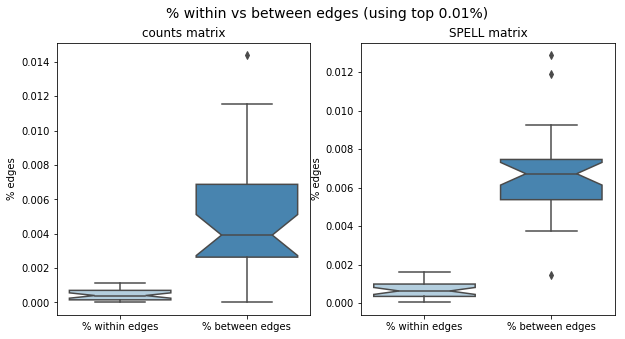

In [32]:
# Make boxplot for number of edges within vs between genes in gene sets/regulons
fig2, axes2 = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

fig2 = sns.boxplot(
    data=pao1_counts_stats_melt,
    x="variable",
    y="value",
    palette="Blues",
    notch=True,
    ax=axes2[0],
)

fig2 = sns.boxplot(
    data=pao1_spell_stats_melt,
    x="variable",
    y="value",
    palette="Blues",
    notch=True,
    ax=axes2[1],
)
axes2[0].set_title("counts matrix")
axes2[1].set_title("SPELL matrix")
axes2[0].set_ylabel("% edges")
axes2[1].set_ylabel("% edges")
axes2[0].set_xlabel("")
axes2[1].set_xlabel("")
plt.suptitle(f"% within vs between edges (using top {top_percent}%)", fontsize=14)

In [33]:
# Save plot
# fig1.figure.savefig(f"pao1_within_vs_between_edges_top_{top_percent}_per_regulon.svg", dpi=300)
# fig2.figure.savefig(f"pao1_within_vs_between_edges_top_{top_percent}.svg", dpi=300)